# Import Dependensi dan Variabel

In [237]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from statsmodels.formula.api import ols

# Import Data

In [238]:
df_gravimetri = pd.read_csv('hasil/ET Aktual Gravimetri.csv')
df_bc = pd.read_csv('hasil/Estimasi ET Blaney-Criddle.csv')
df_hs = pd.read_csv('hasil/Estimasi ET Hargreaves-Samani.csv')
df_pm = pd.read_csv('hasil/Estimasi ET Penman-Monteith.csv')

# Heatmap Data

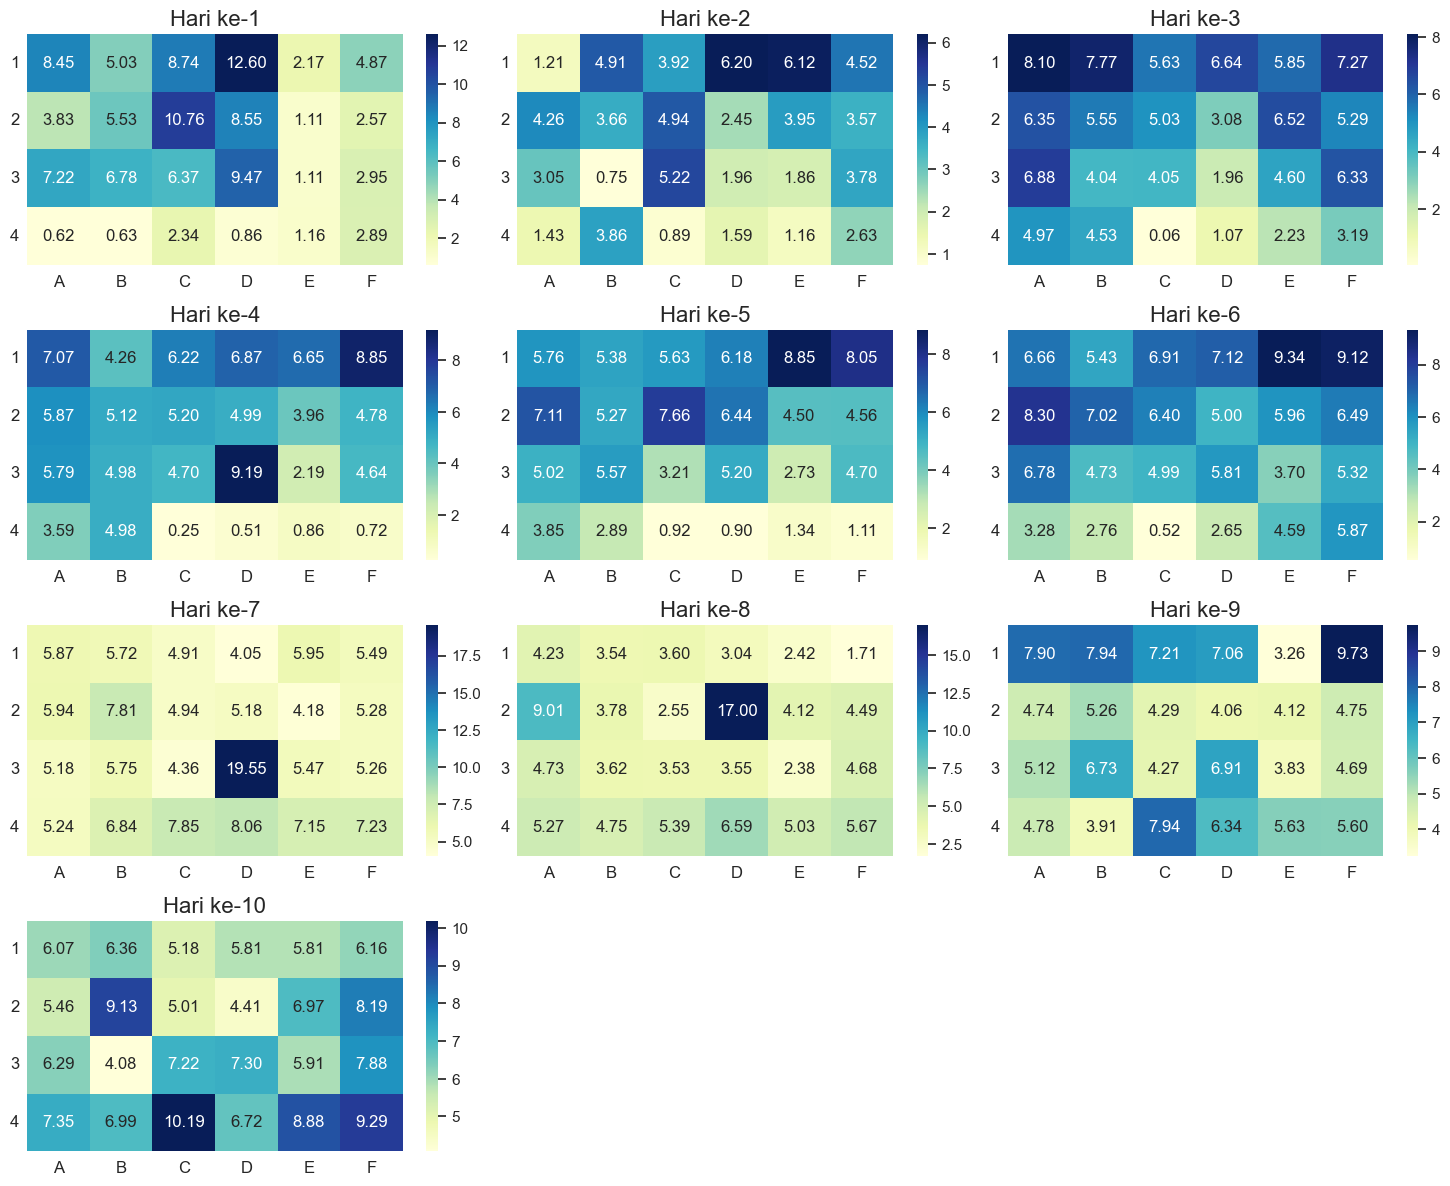

In [239]:
df_gravimetri.set_index('Num Day', inplace=True)

# Plot heatmaps
fig, axes = plt.subplots(4, 3, figsize=(15, 12))  # 4x3 grid
axes = axes.flatten()

for i, (day, data) in enumerate(df_gravimetri.iterrows()):
    # Reshape data untuk heatmap
    day_data = data.values.reshape(4, 6)  # Reshape ke (4x6)
    
    # Plot heatmap
    sns.heatmap(
        day_data, annot=True, fmt=".2f", cmap="YlGnBu",
        xticklabels=[], yticklabels=[], ax=axes[i]
    )
    axes[i].set_title(f"Hari ke-{i+1}", fontsize=16)

    # Tambahkan label X (A-F) dan Y (1-4)
    for col in range(6):
        axes[i].text(col + 0.5, 4.3, f"{chr(65 + col)}", ha="center", va="center", fontsize=12)
    for row in range(4):
        axes[i].text(-0.2, row + 0.5, f"{row + 1}", ha="center", va="center", fontsize=12)

# Hilangkan subplot kosong jika jumlah hari kurang dari 12
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [240]:
df_gravimetri.index = range(1, len(df_gravimetri) + 1)
df_gravimetri.index.name = "Num Day"

In [241]:
df_gravimetri.head(2)

,A1,A2,A3,A4,B1,B2,B3,B4,C1,C2,...,D3,D4,E1,E2,E3,E4,F1,F2,F3,F4
Num Day,,,,,,,,,,,,,,,,,,,,,
1,8.4480,5.0304,8.7360,12.5952,2.173333,4.866667,3.826667,5.533333,10.755918,8.551837,...,6.3750,9.4650,1.108148,2.951111,0.622222,0.628148,2.3376,0.8592,1.1616,2.8896
2,1.2084,4.9140,3.9156,6.2004,6.124667,4.524667,4.258000,3.658000,4.935551,2.447388,...,5.2155,1.9605,1.855037,3.780963,1.428370,3.863926,0.8940,1.5948,1.1580,2.6268


# Cek Outlier

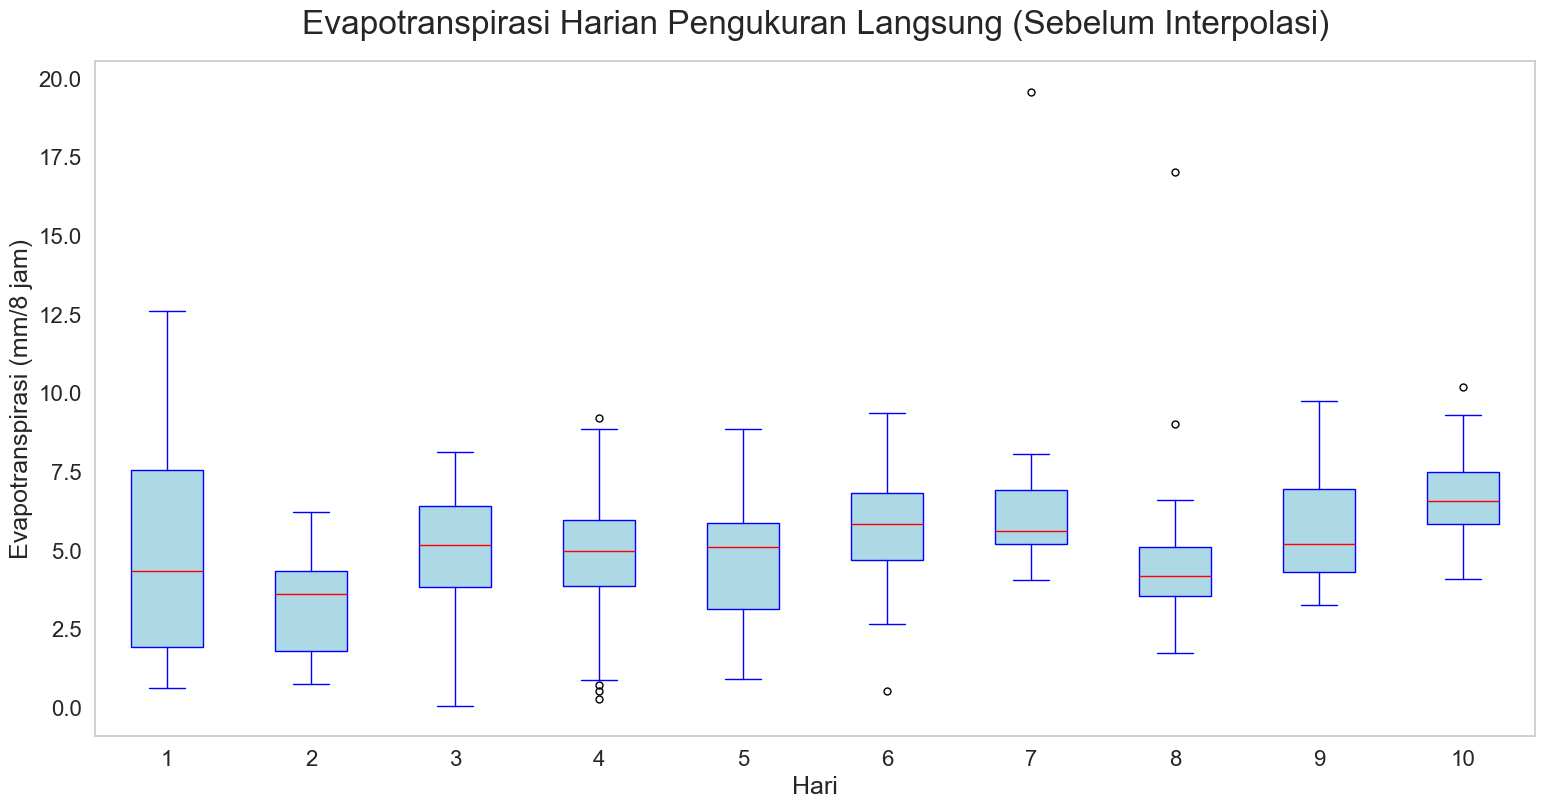

In [242]:
# Reset index to make 'Num Day' a column again
df_gravimetri_reset = df_gravimetri.reset_index()

# Convert df_gravimetri to long format
data_aktual_long = df_gravimetri_reset.melt(id_vars=['Num Day'], var_name='Day', value_name='Evapotranspirasi')

# Membuat plot boxplot dengan ukuran besar
fig, ax = plt.subplots(figsize=(18, 9))  # Ukuran figure diperbesar
boxplot = data_aktual_long.boxplot(by='Num Day', column='Evapotranspirasi', grid=False, patch_artist=True,
           boxprops=dict(facecolor='lightblue', color='blue'),
           whiskerprops=dict(color='blue'),
           capprops=dict(color='blue'),
           medianprops=dict(color='red'),
           flierprops=dict(marker='o', color='red', markersize=5),
           ax=ax)

# Tambahkan judul dan label
ax.set_title('Evapotranspirasi Harian Pengukuran Langsung (Sebelum Interpolasi)', fontsize=24, pad=20)
ax.set_xlabel('Hari', fontsize=18)
ax.set_ylabel('Evapotranspirasi (mm/8 jam)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Ubah keterangan sumbu x menjadi angka 1 sampai 10
ax.set_xticklabels(range(1, 11))

plt.suptitle('')

# Tampilkan plot
plt.show()


# Penanganan Outlier

In [243]:
# Function to detect outliers using IQR
def detect_outliers(df, multiplier=3):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    is_outlier = (df < (Q1 - multiplier * IQR)) | (df > (Q3 + multiplier * IQR))
    return is_outlier

In [244]:
# Function to handle outliers and fill missing values using IterativeImputer
def handle_outliers_with_iterative(df, max_iterations=100, multiplier=5):
    imputer = IterativeImputer(max_iter=10, tol=1e-1000, random_state=0)
    iteration = 0
    best_df = df.copy()
    min_outliers = float('inf')

    while iteration < max_iterations:
        # print(f"Iteration {iteration + 1}")
        # Detect outliers
        outliers = detect_outliers(df, multiplier=multiplier)
        num_outliers = outliers.sum().sum()

        # If the current iteration has fewer outliers, update the best_df
        if num_outliers < min_outliers:
            min_outliers = num_outliers
            best_df = df.copy()

        # If no outliers are detected, break the loop
        if num_outliers == 0:
            break

        # Replace outliers with NaN
        df[outliers] = np.nan

        # Apply Iterative imputation
        df.iloc[:, :] = imputer.fit_transform(df)

        iteration += 1

    print(f"Best iteration with {min_outliers} outliers")
    return best_df


In [245]:
# Handle outliers and fill missing values
df_gravimetri_interpolate = handle_outliers_with_iterative(df_gravimetri)

# Remove all data for Day 7 and interpolate
df_gravimetri_interpolate.loc[3] = np.nan
df_gravimetri_interpolate = df_gravimetri_interpolate.interpolate(method='polynomial', order=2, axis=0)
df_gravimetri_interpolate.loc[6] = np.nan
df_gravimetri_interpolate.loc[7] = np.nan
df_gravimetri_interpolate = df_gravimetri_interpolate.interpolate(method='polynomial', order=2, axis=0)

# # Detect and handle outliers again using IterativeImputer
df_gravimetri_interpolate = handle_outliers_with_iterative(df_gravimetri_interpolate)

d:\OneDrive\04. University of Jember\01. Physics Academics\TUGAS AKHIR\04. Program-Evapotranspiration-Analysis\.venv\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Best iteration with 0 outliers


d:\OneDrive\04. University of Jember\01. Physics Academics\TUGAS AKHIR\04. Program-Evapotranspiration-Analysis\.venv\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
d:\OneDrive\04. University of Jember\01. Physics Academics\TUGAS AKHIR\04. Program-Evapotranspiration-Analysis\.venv\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
d:\OneDrive\04. University of Jember\01. Physics Academics\TUGAS AKHIR\04. Program-Evapotranspiration-Analysis\.venv\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
d:\OneDrive\04. University of Jember\01. Physics Academics\TUGAS AKHIR\04. Program-Evapotranspiration-Analysis\.venv\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Ear

Best iteration with 4 outliers


d:\OneDrive\04. University of Jember\01. Physics Academics\TUGAS AKHIR\04. Program-Evapotranspiration-Analysis\.venv\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


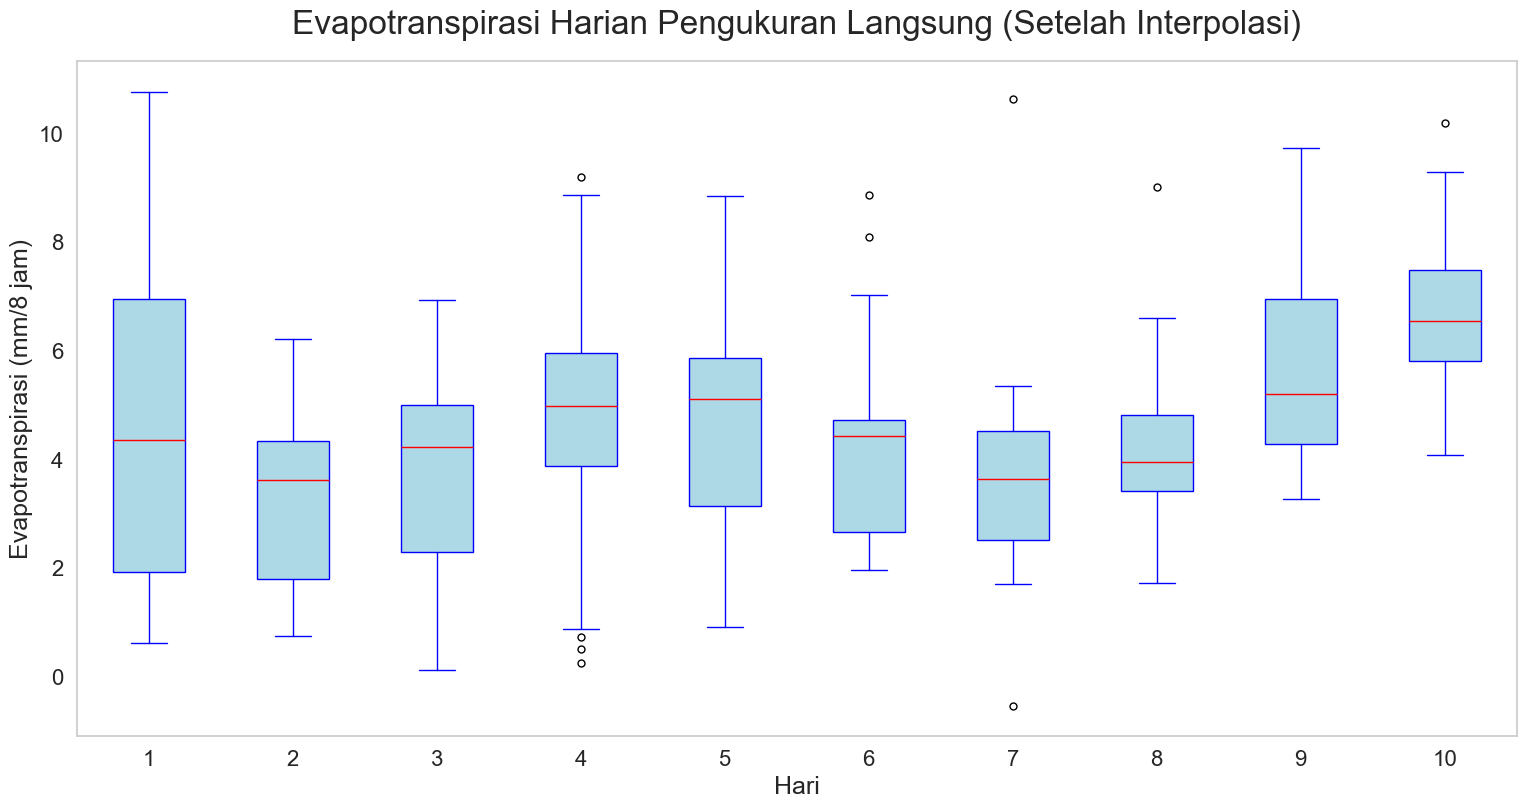

In [246]:
# Reset index to make 'Num Day' a column again
df_gravimetri_reset = df_gravimetri_interpolate.reset_index()

# Convert df_gravimetri to long format
data_aktual_long = df_gravimetri_reset.melt(id_vars=['Num Day'], var_name='Day', value_name='Evapotranspirasi')

# Membuat plot boxplot dengan ukuran besar
fig, ax = plt.subplots(figsize=(18, 9))  # Ukuran figure diperbesar
boxplot = data_aktual_long.boxplot(by='Num Day', column='Evapotranspirasi', grid=False, patch_artist=True,
           boxprops=dict(facecolor='lightblue', color='blue'),
           whiskerprops=dict(color='blue'),
           capprops=dict(color='blue'),
           medianprops=dict(color='red'),
           flierprops=dict(marker='o', color='red', markersize=5),
           ax=ax)

# Tambahkan judul dan label
ax.set_title('Evapotranspirasi Harian Pengukuran Langsung (Setelah Interpolasi)', fontsize=24, pad=20)
ax.set_xlabel('Hari', fontsize=18)
ax.set_ylabel('Evapotranspirasi (mm/8 jam)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Ubah keterangan sumbu x menjadi angka 1 sampai 10
ax.set_xticklabels(range(1, 11))

plt.suptitle('')

# Tampilkan plot
plt.show()


# Perbandingan Data Aktual dan Estimasi

In [247]:
df_bc = df_bc.reset_index(drop=True)
df_bc.index = df_bc.index + 1

df_hs = df_hs.reset_index(drop=True)
df_hs.index = df_hs.index + 1

df_pm = df_pm.reset_index(drop=True)
df_pm.index = df_pm.index + 1

In [248]:
# Define df_gravimetri_analisis
df_gravimetri_analisis = pd.DataFrame(index=df_gravimetri_interpolate.index)

# Menghitung rata-rata harian dari semua tanaman
df_gravimetri_analisis['Average'] = df_gravimetri_interpolate.iloc[:, 1:].mean(axis=1)

# Menghitung median untuk setiap hari
df_gravimetri_analisis['Median'] = df_gravimetri_interpolate.iloc[:, 1:-3].median(axis=1)

# Menghitung Standar Deviasi untuk setiap hari
df_gravimetri_analisis['STDEV'] = df_gravimetri_interpolate.iloc[:, 1:-1].std(axis=1)

# Menghitung IQR (Interquartile Range) untuk setiap hari
Q1 = df_gravimetri_interpolate.iloc[:, 1:-2].quantile(0.25, axis=1)
Q2 = df_gravimetri_interpolate.iloc[:, 1:-2].quantile(0.5, axis=1)
Q3 = df_gravimetri_interpolate.iloc[:, 1:-2].quantile(0.75, axis=1)
Q4 = df_gravimetri_interpolate.iloc[:, 1:-2].quantile(1, axis=1)

df_gravimetri_analisis['Q1'] = Q1
df_gravimetri_analisis['Q2'] = Q2
df_gravimetri_analisis['Q3'] = Q3
df_gravimetri_analisis['Q4'] = Q4
df_gravimetri_analisis['IQR'] = Q3 - Q1

df_gravimetri_analisis = df_gravimetri_analisis.round(2)
df_gravimetri_analisis.head()

,Average,Median,STDEV,Q1,Q2,Q3,Q4,IQR
Num Day,,,,,,,,
1,4.45,4.95,3.20,2.17,4.87,6.85,10.76,4.67
2,3.33,3.82,1.65,1.96,3.78,4.52,6.20,2.56
3,3.80,4.36,1.89,2.58,4.36,5.16,6.93,2.58
4,4.57,4.98,2.31,4.26,4.98,5.87,9.19,1.60
5,4.65,5.23,2.19,3.85,5.20,6.18,8.85,2.33


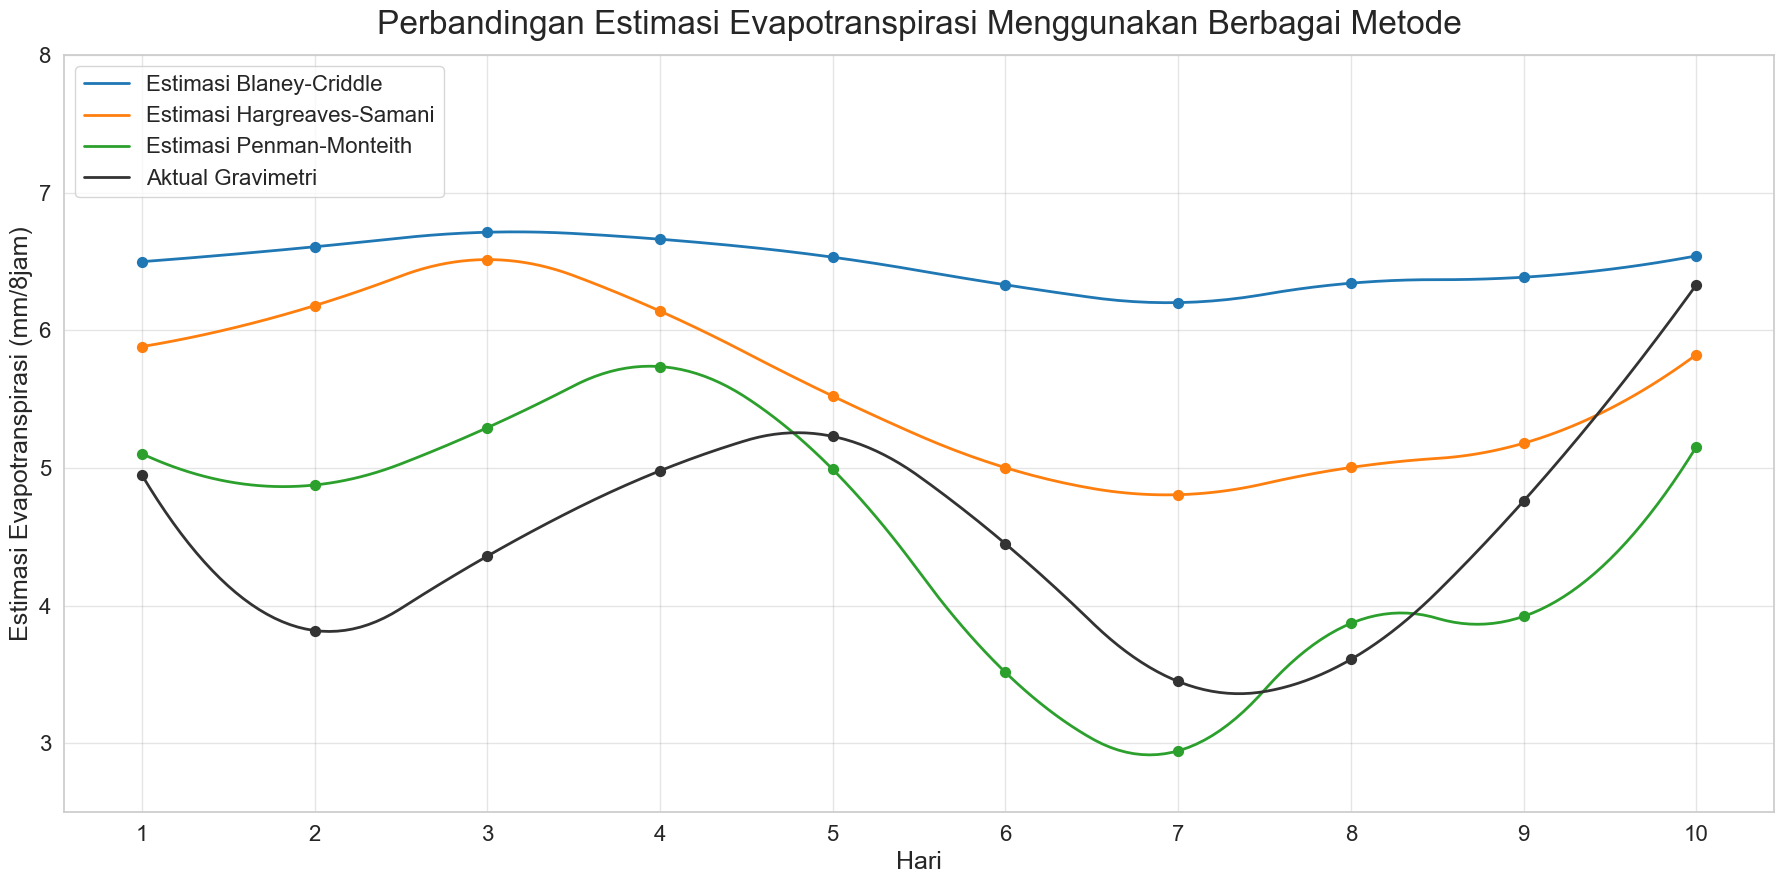

In [249]:
from scipy.interpolate import make_interp_spline

sns.set(style="whitegrid", palette="Set2")
plt.figure(figsize=(18, 9))

# Fungsi untuk membuat kurva melengkung dengan spline interpolasi
def smooth_curve(x, y, num_points=200):
    x_new = np.linspace(x.min(), x.max(), num_points)
    spline = make_interp_spline(x, y, k=2)  # k=3 untuk cubic spline
    y_smooth = spline(x_new)
    return x_new, y_smooth

# Plot data Blaney-Criddle
x_bc, y_bc = smooth_curve(df_bc.index, df_bc['ET Total'])
plt.plot(x_bc, y_bc, label='Estimasi Blaney-Criddle', color='#1f77b4', linewidth=2)
plt.scatter(df_bc.index, df_bc['ET Total'], color='#1f77b4', s=50, zorder=3)

# Plot data Hargreaves-Samani
x_hs, y_hs = smooth_curve(df_hs.index, df_hs['ET Total'])
plt.plot(x_hs, y_hs, label='Estimasi Hargreaves-Samani', color='#ff7f0e', linewidth=2)
plt.scatter(df_hs.index, df_hs['ET Total'], color='#ff7f0e', s=50, zorder=3)

# Plot data Penman-Monteith
x_pm, y_pm = smooth_curve(df_pm.index, df_pm['ET Total'])
plt.plot(x_pm, y_pm, label='Estimasi Penman-Monteith', color='#2ca02c', linewidth=2)
plt.scatter(df_pm.index, df_pm['ET Total'], color='#2ca02c', s=50, zorder=3)

# Plot data gravimetri
x_grav, y_grav = smooth_curve(df_gravimetri_analisis.index, df_gravimetri_analisis['Median'])
plt.plot(x_grav, y_grav, label='Aktual Gravimetri', color='#333333', linewidth=2)
plt.scatter(df_gravimetri_analisis.index, df_gravimetri_analisis['Median'], color='#333333', s=50, zorder=3)

# Judul dan label sumbu
plt.title('Perbandingan Estimasi Evapotranspirasi Menggunakan Berbagai Metode', fontsize=24, pad=15)
plt.xlabel('Hari', fontsize=18)
plt.ylabel('Estimasi Evapotranspirasi (mm/8jam)', fontsize=18)

# Menentukan ticks pada sumbu x dengan interval 1
x_min = min(df_bc.index.min(), df_hs.index.min(), df_pm.index.min(), df_gravimetri_analisis.index.min())
x_max = max(df_bc.index.max(), df_hs.index.max(), df_pm.index.max(), df_gravimetri_analisis.index.max())
plt.xticks(np.arange(x_min, x_max + 1, 1), fontsize=16)  # Rentang 1 untuk label x

plt.yticks(fontsize=16)

# Grid dan legenda
plt.grid(True, linestyle='-', color='gray', alpha=0.2)
plt.legend(fontsize=16, frameon=True, loc='upper left')

# Rentang sumbu y
plt.ylim(2.5, 8)
plt.tight_layout()

# Tampilkan grafik
plt.show()

In [250]:
df_gravimetri_analisis

,Average,Median,STDEV,Q1,Q2,Q3,Q4,IQR
Num Day,,,,,,,,
1,4.45,4.95,3.20,2.17,4.87,6.85,10.76,4.67
2,3.33,3.82,1.65,1.96,3.78,4.52,6.20,2.56
3,3.80,4.36,1.89,2.58,4.36,5.16,6.93,2.58
4,4.57,4.98,2.31,4.26,4.98,5.87,9.19,1.60
5,4.65,5.23,2.19,3.85,5.20,6.18,8.85,2.33
6,4.29,4.45,1.82,2.70,4.44,4.74,8.87,2.05
7,3.74,3.45,2.09,2.28,3.54,4.51,10.62,2.23
8,4.16,3.61,1.62,3.04,3.62,4.73,9.01,1.69
9,5.57,4.76,1.68,4.27,4.78,6.91,9.73,2.64


# Analisis Parameter

In [251]:
df_analisis_parameter = df_gravimetri_analisis[['Median']].copy()
df_analisis_parameter.rename(columns={'Median': 'Gravimetri'}, inplace=True)

df_analisis_parameter.loc[:, 'Blaney-Criddle'] = df_bc['ET Total']
df_analisis_parameter.loc[:, 'Hargreaves-Samani'] = df_hs['ET Total']
df_analisis_parameter.loc[:, 'Penman-Monteith'] = df_pm['ET Total']
df_analisis_parameter

,Gravimetri,Blaney-Criddle,Hargreaves-Samani,Penman-Monteith
Num Day,,,,
1,4.95,6.498712,5.881888,5.104162
2,3.82,6.606921,6.179544,4.876762
3,4.36,6.712646,6.514070,5.293068
4,4.98,6.662035,6.140098,5.737096
5,5.23,6.531469,5.522609,4.990299
6,4.45,6.330886,5.002684,3.516000
7,3.45,6.201563,4.806410,2.945929
8,3.61,6.342530,5.004103,3.871651
9,4.76,6.386000,5.180139,3.922581


In [252]:
# Fungsi menghitung akurasi
def calculate_akurasi(aktual, estimasi):
  error = np.abs(np.mean(estimasi) - np.mean(aktual)) / np.mean(aktual)
  akurasi = (1 - error) * 100
  return akurasi

In [253]:
# Fungsi untuk menghitung RMSE
def calculate_rmse(actual, estimates):
    return np.sqrt(mean_squared_error(actual, estimates))

In [254]:
# Fungsi untuk menghitung MAE
def calculate_mae(actual, estimates):
    return mean_absolute_error(actual, estimates)

In [255]:
# Fungsi untuk menghitung MBE
def calculate_mbe(actual, estimates):
    return np.mean(estimates - actual)

In [256]:
# Menghitung Akurasi, RMSE, MAE, dan MBE untuk setiap metode
results = {
    'Metode': ['Blaney-Criddle', 'Hargreaves-Samani', 'Penman-Monteith'],
    'Akurasi': [],
    'RMSE': [],
    'MAE': [],
    'MBE': []
}

# Define the actual values
actual = df_analisis_parameter['Gravimetri']

for column in results['Metode']:
    results['Akurasi'].append(calculate_akurasi(actual, df_analisis_parameter[column]))
    results['RMSE'].append(calculate_rmse(actual, df_analisis_parameter[column]))
    results['MAE'].append(calculate_mae(actual, df_analisis_parameter[column]))
    results['MBE'].append(calculate_mbe(actual, df_analisis_parameter[column]))

# Membuat dataframe dari hasil perhitungan
df_results = pd.DataFrame(results)
df_results = df_results.round(3)
df_results

,Metode,Akurasi,RMSE,MAE,MBE
0,Blaney-Criddle,58.917,2.037,1.887,1.887
1,Hargreaves-Samani,77.983,1.305,1.113,1.011
2,Penman-Monteith,98.849,0.770,0.685,-0.053


# ANOVA

In [343]:
df_data_anova = pd.read_csv('hasil/Data Anova.csv')
df_data_anova.head()

,Kode,Day,Berat_Tanaman,Intensitas_Matahari,Tinggi_Tanaman,Luas_Permukaan_Wadah
0,A1,day 05,2.181938,78100.0,25,156.25
1,A2,day 05,3.039563,78100.0,40,156.25
2,A3,day 05,3.915938,78100.0,45,156.25
3,A4,day 05,3.264563,78100.0,60,156.25
4,B1,day 05,3.590562,78100.0,25,225.00


In [344]:
mean_values = df_gravimetri_interpolate.mean()
df_mean = mean_values.to_frame(name='Evapotranspirasi')
df_mean = df_mean.reset_index(names='Kode')

df_data_anova = df_data_anova.merge(df_mean, left_on="Kode", right_on="Kode", how="left")
df_data_anova.head()

,Kode,Day,Berat_Tanaman,Intensitas_Matahari,Tinggi_Tanaman,Luas_Permukaan_Wadah,Evapotranspirasi
0,A1,day 05,2.181938,78100.0,25,156.25,5.048333
1,A2,day 05,3.039563,78100.0,40,156.25,4.853148
2,A3,day 05,3.915938,78100.0,45,156.25,5.131362
3,A4,day 05,3.264563,78100.0,60,156.25,5.486978
4,B1,day 05,3.590562,78100.0,25,225.00,5.421034


In [345]:
print(df_data_anova['Tinggi_Tanaman'].unique())
print(df_data_anova['Luas_Permukaan_Wadah'].unique())
print(df_data_anova['Intensitas_Matahari'].unique())

[25 40 45 60]
[156.25 225.   306.25 400.   506.25 625.  ]
[78100.   68837.5  81381.25 63787.5  64418.75 41850.   72318.75 46100.
 49925.   65481.25]


In [346]:
model = ols('Evapotranspirasi ~ C(Tinggi_Tanaman) + C(Luas_Permukaan_Wadah)', data=df_data_anova).fit()
anova = sm.stats.anova_lm(model, typ=3)
print("Tabel Anova Hubungan Tinggi dan Luas Permukaan Wadah Terhadap Evapotranspirasi")
anova

Tabel Anova Hubungan Tinggi dan Luas Permukaan Wadah Terhadap Evapotranspirasi


,sum_sq,df,F,PR(>F)
Intercept,683.342659,1.0,3061.567299,2.865823e-135
C(Tinggi_Tanaman),1.837011,3.0,2.743442,4.390024e-02
C(Luas_Permukaan_Wadah),135.713686,5.0,121.607096,1.175298e-62
Residual,51.559263,231.0,NaN,NaN


In [347]:
model_interaksi = ols('Evapotranspirasi ~ C(Tinggi_Tanaman) * C(Luas_Permukaan_Wadah)', data=df_data_anova).fit()
anova_interaksi = sm.stats.anova_lm(model_interaksi, typ=3)
anova_interaksi


,sum_sq,df,F,PR(>F)
Intercept,2.548567e+02,1.0,9.708934e+30,0.0
C(Tinggi_Tanaman),2.107518e+00,3.0,2.676242e+28,0.0
C(Luas_Permukaan_Wadah),7.010063e+01,5.0,5.341059e+29,0.0
C(Tinggi_Tanaman):C(Luas_Permukaan_Wadah),5.155926e+01,15.0,1.309456e+29,0.0
Residual,5.669938e-27,216.0,NaN,NaN


In [348]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(
    endog=df_data_anova['Evapotranspirasi'],
    groups=df_data_anova['Tinggi_Tanaman'].astype(str) + ':' + df_data_anova['Luas_Permukaan_Wadah'].astype(str),
    alpha=0.05
)
# Menampilkan tabel hasil Tukey HSD
print(tukey.summary())

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj  lower   upper  reject
---------------------------------------------------------
25:156.25  25:225.0   0.3727   0.0  0.3727  0.3727   True
25:156.25 25:306.25   0.4019   0.0  0.4019  0.4019   True
25:156.25  25:400.0  -0.0287   0.0 -0.0287 -0.0287   True
25:156.25 25:506.25  -2.3734   0.0 -2.3734 -2.3734   True
25:156.25  25:625.0  -1.7135   0.0 -1.7135 -1.7135   True
25:156.25 40:156.25  -0.1952   0.0 -0.1952 -0.1952   True
25:156.25  40:225.0    0.423   0.0   0.423   0.423   True
25:156.25 40:306.25  -0.6509   0.0 -0.6509 -0.6509   True
25:156.25  40:400.0  -0.9052   0.0 -0.9052 -0.9052   True
25:156.25 40:506.25  -0.3172   0.0 -0.3172 -0.3172   True
25:156.25  40:625.0  -1.7906   0.0 -1.7906 -1.7906   True
25:156.25 45:156.25    0.083   0.0   0.083   0.083   True
25:156.25  45:225.0   1.4216   0.0  1.4216  1.4216   True
25:156.25 45:306.25  -0.8174   0.0 -0.8174 -0.8174   True
25:156.25  45:

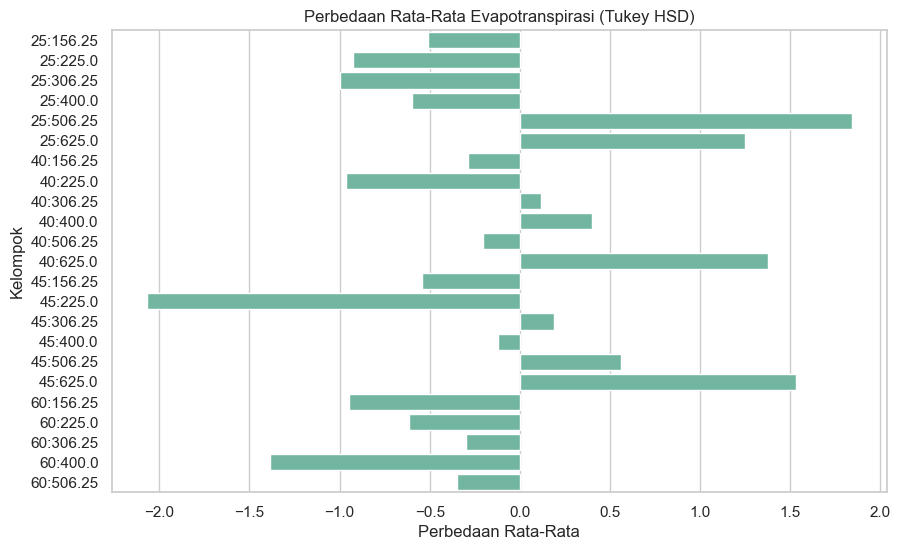

In [352]:
# Contoh visualisasi hasil Tukey
tukey_summary = tukey.summary()
tukey_results_df = pd.DataFrame(data=tukey_summary.data[1:], columns=tukey_summary.data[0])

plt.figure(figsize=(10, 6))
sns.barplot(x='meandiff', y='group1', data=tukey_results_df, errorbar=None)
plt.title('Perbedaan Rata-Rata Evapotranspirasi (Tukey HSD)')
plt.xlabel('Perbedaan Rata-Rata')
plt.ylabel('Kelompok')
plt.show()